# SR in / out

**Goal:** Patrick saw a **5%** improvement for the SM splitting the SR into 2, so I was curious if I might be able to see a similar improvement, and *if so*, also see if it was orthogonal to $\Delta \eta_{hh}$ cats, and some guestimates for how much we might gain by nudging out the SR center out a bit too!!

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

from statsmodels.stats.weightstats import DescrStatsW

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os

os.sys.path+= ['../RRevolution/code/','../code/','../PAG-opt/']
from utils import mcToYr, L
from analysis import getXhh
from triggerBuckets import trigger_lut
from processMNTs import get_xsec

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'statsmodels'

**Load in the data**

In [ ]:
yr = 18
x1,y1 = 124,117

In [2]:
fDir = '/u/ki/nhartman/gpfs/diHiggs4b/data/RR/nom_trigs_unblind'
rwTag = f'_min_dR_VEC_sr_{x1}_{y1}_NN_100_bootstraps'

f = uproot.open(f'{fDir}/data{yr}{rwTag}.root')

bcols = ['m_hh','m_h1','m_h2','dEta_hh','X_wt_tag','ntag',
         f'NN_d24_weight_bstrap_med_{yr}', f'NN_d24_weight_VRderiv_bstrap_med_{yr}',
         f'NN_d24_weight_bstrap_IQR_{yr}']


sr = f['sig'].pandas.df(bcols)
vr = f['validation'].pandas.df(bcols)
cr = f['control'].pandas.df(bcols)

NameError: name 'x1' is not defined

In [15]:
for df in [sr,vr,cr]:
    df['w_2b']    = f[f'NN_norm_bstrap_med_{yr}']._fVal * df[f'NN_d24_weight_bstrap_med_{yr}']
    df['w_2b_VR'] = f[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal * df[f'NN_d24_weight_VRderiv_bstrap_med_{yr}']
    
    df[f'Xhh_{x1}_{y1}'] = getXhh(*df[['m_h1','m_h2']].values.T,x1,y1)

In [39]:
bdf = pd.concat([sr,vr,cr],ignore_index=True)

In [8]:
mc = 'mc16e'
assert (mcToYr[mc]-2000) == yr

scols = ['m_hh','m_h1','m_h2','mc_sf','dEta_hh','X_wt','ntag','pass_vbf_sel','truth_mhh']

sFile = f'../data/RR/NNT_DEC20_MDR_VEC/MC/600043_{mc}/NanoNTuple.root'
tName = 'fullmassplane'
sdf = uproot.open(sFile)[tName].pandas.df(scols)

# Apply the lumi uncertainty - and calculate the *new* SR / cut the unwanted events
sdf['mc_sf']     *= L[yr]
sdf['truth_mhh'] *= 0.001

sdf[f'Xhh_{x1}_{y1}'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)

sdf = sdf[ (sdf.ntag>=4) & (~sdf.pass_vbf_sel)]


### Step 1: Compare the significance if we could use an SR with a radius of 2.2.

In [130]:
def hhokeyPokey(sdf,bdf,cout=1,cin=1.6,n=40,r=(200,1200)):
    '''
    Return the histograms for dividing the SR into two.
    '''

    m_in = (sdf.Xhh_124_117 < cin) 
    m_out = (sdf.Xhh_124_117 > cin) & (sdf.Xhh_124_117 < cout)

    if type(n) == list:
        s_in = np.histogram2d(*sdf.loc[m_in,['m_hh','dEta_hh']].values.T,
                              n,r,weights=sdf.loc[m_in,'mc_sf'])[0]
        s_out = np.histogram2d(*sdf.loc[m_out,['m_hh','dEta_hh']].values.T,
                               n,r,weights=sdf.loc[m_out,'mc_sf'])[0]
    else:
        s_in = np.histogram(sdf.loc[m_in,'m_hh'],n,r,
                            weights=sdf.loc[m_in,'mc_sf'])[0]
        s_out = np.histogram(sdf.loc[m_out,'m_hh'],n,r,
                             weights=sdf.loc[m_out,'mc_sf'])[0]
    print(f'S_in: {np.sum(s_in):.2f}, S_out: {np.sum(s_out):.2f}')

    m_in = (bdf.Xhh_124_117 < cin) 
    m_out = (bdf.Xhh_124_117 > cin) & (bdf.Xhh_124_117 < cout)

    if type(n) == list:
        b_in = np.histogram2d(*bdf.loc[m_in,['m_hh','dEta_hh']].values.T,
                              n,r,weights=bdf.loc[m_in,'w_2b'])[0]
        b_out = np.histogram2d(*bdf.loc[m_out,['m_hh','dEta_hh']].values.T,
                               n,r,weights=bdf.loc[m_out,'w_2b'])[0]
    else:
        b_in = np.histogram(bdf.loc[m_in,'m_hh'],n,r,
                            weights=bdf.loc[m_in,'w_2b'])[0]
        b_out = np.histogram(bdf.loc[m_out,'m_hh'],n,r,
                             weights=bdf.loc[m_out,'w_2b'])[0]
    
    z_in  = np.nan_to_num(s_in  / np.sqrt(b_in))
    z_out = np.nan_to_num(s_out / np.sqrt(b_out))

    print(f'B_in: {np.sum(b_in):.1f}, B_out: {np.sum(b_out):.1f}')
    
    return s_in, s_out, b_in, b_out, z_in, z_out

In [68]:
e = np.linspace(200,1200,41)
xx = 0.5 * (e[1:]+e[:-1])

In [74]:
s = np.histogram(sdf.loc[sdf.Xhh_124_117 < 1.6,'m_hh'],40,(200,1200),
                 weights=sdf.loc[sdf.Xhh_124_117 < 1.6,'mc_sf'])[0]

b = np.histogram(sr.loc[sr.Xhh_124_117<1.6,'m_hh'],40,(200,1200),
                 weights=sr.loc[sr.Xhh_124_117<1.6,'w_2b'])[0]
z_nom = np.nan_to_num(s/np.sqrt(b))

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


S_in: 10.60, S_out: 8.31
B_in: 13643.5, B_out: 28246.5


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


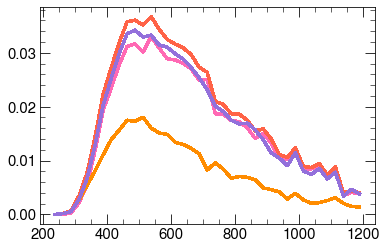

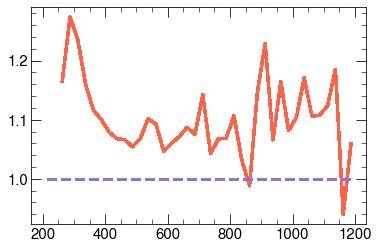

In [107]:
s_in,s_out, b_in,b_out, z_in,z_out = hhokeyPokey(sdf,bdf,2.1,1.2)

plt.plot(xx,z_in,'hotpink')
plt.plot(xx,z_out,'darkorange')

z = np.sqrt(z_in**2 + z_out**2)
plt.plot(xx, z, 'tomato')

plt.plot(xx, z_nom, 'mediumpurple')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Significance',fontsize=18)


plt.figure()
plt.plot(xx,z/ z_nom,'tomato')
plt.plot(xx,np.ones_like(xx),'mediumpurple',ls='--')


## Step 2: Compare the significance if we need to keep $X_{hh} < 1.6$

A.k.a, what if we can't *increase* the size of the SR?

Try an inner region cut off of 1.


S_in: 7.53, S_out: 7.45
B_in: 8574.7, B_out: 15802.0
1.0645796035232042


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


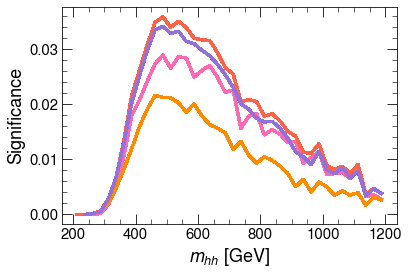

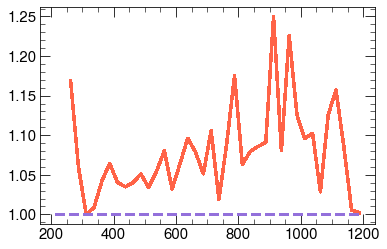

In [111]:
s_in,s_out, b_in,b_out, z_in,z_out = hhokeyPokey(sdf,bdf,1.6,0.95)

plt.plot(xx,z_in,'hotpink')
plt.plot(xx,z_out,'darkorange')

z = np.nan_to_num(np.sqrt(z_in**2 + z_out**2))
plt.plot(xx, z, 'tomato')

plt.plot(xx, z_nom, 'mediumpurple')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Significance',fontsize=18)

plt.figure()
plt.plot(xx,z/ z_nom,'tomato')
plt.plot(xx,np.ones_like(xx),'mediumpurple',ls='--')

print(np.sqrt(np.sum(z**2))/np.sqrt(np.sum(np.nan_to_num(z_nom)**2)))

6% better, roughly comparable with what Patrick had.

But also, this was just taking the inner cut as the median for the correctly paired signal... could **test** if this is the same if we instead compare the gain in significance as we vary the inner cut??

In [112]:
Xins = np.linspace(0,1.6,33)
zs = []

for cin in Xins:
    s_in,s_out, b_in,b_out, z_in,z_out = hhokeyPokey(sdf,bdf,1.6,cin)

    z_in  = np.nan_to_num(s_in  / np.sqrt(b_in))
    z_out = np.nan_to_num(s_out / np.sqrt(b_out))
    
    z = np.sqrt(z_in**2 + z_out**2)
    zs.append(np.sum(z))
    
zs = np.array(zs)

S_in: 0.00, S_out: 14.98
B_in: 0.0, B_out: 24376.8
S_in: 0.03, S_out: 14.95
B_in: 21.1, B_out: 24355.7
S_in: 0.10, S_out: 14.88
B_in: 91.4, B_out: 24285.3
S_in: 0.24, S_out: 14.74
B_in: 211.9, B_out: 24164.9
S_in: 0.40, S_out: 14.58


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


B_in: 389.2, B_out: 23987.5
S_in: 0.63, S_out: 14.35
B_in: 611.1, B_out: 23765.7
S_in: 0.91, S_out: 14.07
B_in: 876.4, B_out: 23500.4
S_in: 1.23, S_out: 13.75
B_in: 1194.7, B_out: 23182.1
S_in: 1.59, S_out: 13.39
B_in: 1532.3, B_out: 22844.5
S_in: 2.02, S_out: 12.96
B_in: 1950.0, B_out: 22426.8
S_in: 2.43, S_out: 12.55
B_in: 2400.3, B_out: 21976.5
S_in: 2.91, S_out: 12.08
B_in: 2898.3, B_out: 21478.4
S_in: 3.42, S_out: 11.56
B_in: 3435.1, B_out: 20941.7
S_in: 3.97, S_out: 11.02
B_in: 4045.6, B_out: 20331.2
S_in: 4.50, S_out: 10.48
B_in: 4680.3, B_out: 19696.5
S_in: 5.10, S_out: 9.89
B_in: 5331.5, B_out: 19045.3
S_in: 5.68, S_out: 9.30
B_in: 6048.3, B_out: 18328.4
S_in: 6.32, S_out: 8.67
B_in: 6848.3, B_out: 17528.4
S_in: 6.92, S_out: 8.06
B_in: 7715.0, B_out: 16661.8
S_in: 7.53, S_out: 7.45
B_in: 8574.7, B_out: 15802.0
S_in: 8.14, S_out: 6.84
B_in: 9509.2, B_out: 14867.5
S_in: 8.76, S_out: 6.22
B_in: 10474.7, B_out: 13902.1
S_in: 9.38, S_out: 5.60
B_in: 11489.5, B_out: 12887.3
S_in: 9.

In [103]:
zs

array([0.64183163, 0.64723142, 0.65467495, 0.65555575, 0.66790885,
       0.67456205, 0.6791108 , 0.68331758, 0.68596177, 0.6904503 ,
       0.68582271, 0.68442607, 0.68129583, 0.67709746, 0.66996625,
       0.65715465, 0.64183163])

Text(0, 0.5, 'Quad sum significance')

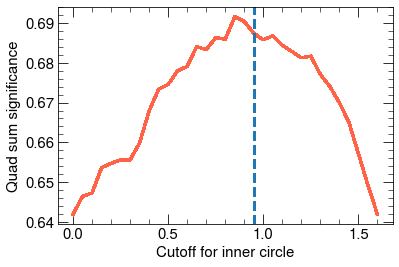

In [122]:
plt.plot(Xins,zs,'tomato')
ylim = plt.ylim()
plt.plot([.95]*2,ylim,ls='--')
plt.ylim(ylim)

plt.xlabel('Cutoff for inner circle')
plt.ylabel('Quad sum significance')


Ok, cool, just choosing the inner cut off at 0.95... not bad haha!!

Text(0, 0.5, 'Significance imp from 1 SR')

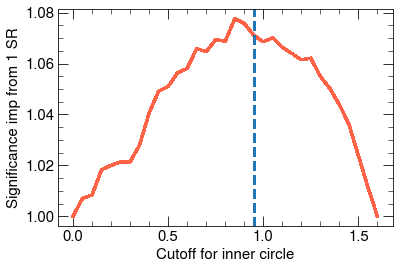

In [121]:
plt.plot(Xins,zs/np.sum(np.nan_to_num(z_nom)),'tomato')
ylim = plt.ylim()
plt.plot([.95]*2,ylim,ls='--')
plt.ylim(ylim)

plt.xlabel('Cutoff for inner circle')
plt.ylabel('Significance imp from 1 SR')

## Step 3: Are these improvements orthogonal to the $\Delta \eta_{hh}$ cats??

In [123]:
zdf = pd.DataFrame(0,[1,2,3,6],['SR: Xhh < 1.6',
                                'SRin: Xhh < 0.95, SRout: Xhh < 1.6',
                                'SRin: Xhh < 1.1, SRout: Xhh < 2.1',])

In [157]:
for c,cin,cout in zip(zdf.columns,[0,0.95,1.1],[1.6,1.6,2.1]):
    for nb in zdf.index:
        
        if nb == 1:
            n = 40
            r = (200,1200)
        else: 
            n = [40,nb]
            r = [(200,1200),(0,1.5)]
            
        s_in,s_out,b_in,b_out,z_in,z_out = hhokeyPokey(sdf,bdf,cout,cin,n,r)
        
        z_in = np.where(z_in > 1e100, 0, z_in)
        z_out = np.where(z_out > 1e100, 0, z_out)
        
        zi = np.sqrt(np.sum(z_in**2 + z_out**2))
        
        zdf.loc[nb,c] = zi
        

S_in: 0.00, S_out: 14.98
B_in: 0.0, B_out: 24376.8
S_in: 0.00, S_out: 14.98
B_in: 0.0, B_out: 24376.8
S_in: 0.00, S_out: 14.98


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


B_in: 0.0, B_out: 24376.8
S_in: 0.00, S_out: 14.98
B_in: 0.0, B_out: 24376.8
S_in: 7.53, S_out: 7.45
B_in: 8574.7, B_out: 15802.0
S_in: 7.53, S_out: 7.45
B_in: 8574.7, B_out: 15802.0
S_in: 7.53, S_out: 7.45
B_in: 8574.7, B_out: 15802.0
S_in: 7.53, S_out: 7.45


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


B_in: 8574.7, B_out: 15802.0
S_in: 9.38, S_out: 9.53
B_in: 11489.5, B_out: 30400.5
S_in: 9.38, S_out: 9.53
B_in: 11489.5, B_out: 30400.5
S_in: 9.38, S_out: 9.53
B_in: 11489.5, B_out: 30400.5
S_in: 9.38, S_out: 9.53
B_in: 11489.5, B_out: 30400.5


In [172]:
zdf

SR: Xhh < 1.6  SRin: Xhh < 0.95, SRout: Xhh < 1.6  \
1       0.122952                            0.130892   
2       0.133547                            0.143129   
3       0.135285                            0.146322   
6       0.137225                            0.151282   

   SRin: Xhh < 1.1, SRout: Xhh < 2.1  
1                           0.132272  
2                           0.143952  
3                           0.146791  
6                           0.150464

In [173]:
zdf/zdf.loc[1,'SR: Xhh < 1.6']

SR: Xhh < 1.6  SRin: Xhh < 0.95, SRout: Xhh < 1.6  \
1       1.000000                            1.064580   
2       1.086172                            1.164102   
3       1.100305                            1.190070   
6       1.116082                            1.230409   

   SRin: Xhh < 1.1, SRout: Xhh < 2.1  
1                           1.075800  
2                           1.170792  
3                           1.193885  
6                           1.223763

In [160]:
s_in,s_out,b_in,b_out,z_in,z_out = hhokeyPokey(sdf,bdf,1.6,0.95,[40,6],[(200,1200),(0,1.5)])
        

S_in: 7.53, S_out: 7.45
B_in: 8574.7, B_out: 15802.0


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [161]:
s_in.shape

(40, 6)

Text(0.5, 1.0, 'signal')

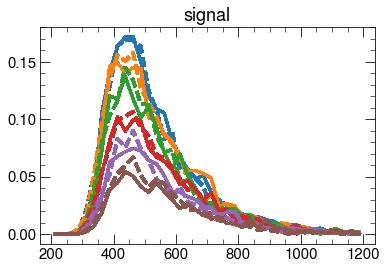

In [162]:
for i,j,c in zip(s_in.T,s_out.T,[f'C{i}' for i in range(6)]):
    plt.plot(xx,i,c,ls='-')
    plt.plot(xx,j,c,ls='--')
plt.title('signal')

Text(0.5, 1.0, 'background')

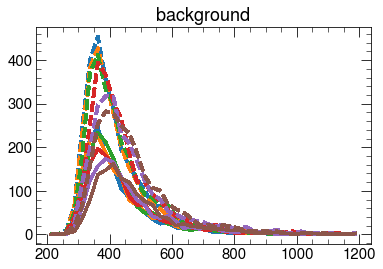

In [163]:
for i,j,c in zip(b_in.T,b_out.T,[f'C{i}' for i in range(6)]):
    plt.plot(xx,i,c,ls='-')
    plt.plot(xx,j,c,ls='--')
plt.title('background')

(0.0, 0.025)

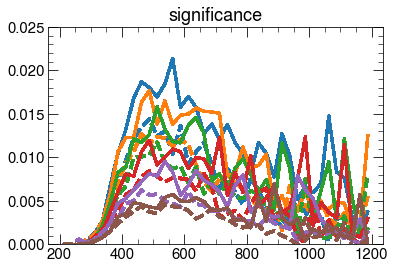

In [171]:
for i,j,c in zip(z_in.T,z_out.T,[f'C{i}' for i in range(6)]):
    plt.plot(xx,i,c,ls='-')
    plt.plot(xx,j,c,ls='--')
plt.title('significance')
plt.ylim(0,0.025)

In [155]:
np.max(z_in)

1.7976931348623157e+308

In [156]:
z_in[z_in > 1e100]

array([1.79769313e+308])